In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
class Neural_net(torch.nn.Module):
    def __init__(self, n_in = 1, n_out =1):
        super(Neural_net, self).__init__()

        self.tanh = torch.nn.Tanh()

        self.layer1 = torch.nn.Linear(n_in,20)
        self.layer2 = torch.nn.Linear(20,20)
        self.layer3 = torch.nn.Linear(20,20)
        self.layer_out = torch.nn.Linear(20,n_out)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer_out(x)

        return x

In [17]:
class predprey_pinn: 

    def __init__(self, epochs, data, c0):
        self.epochs = epochs
        self.model = Neural_net(n_out=2)
        self.domain = torch.linspace(0,int(max(data[0])),100, requires_grad=True).reshape(-1,1)

        self.lbfgs_optimizer = torch.optim.LBFGS(params = self.model.parameters(), lr = 0.001,max_iter = 500)
        self.adam_optimizer = torch.optim.Adam(params = self.model.parameters(), lr = 0.0001)

        self.alpha = 0.25
        self.beta = 0.02
        self.delta = 0.25
        self.gamma = 2

        self.t_dat = torch.tensor(data[0], dtype=torch.float).reshape(-1,1)
        self.x_dat = torch.tensor(data[1],dtype=torch.float)
        self.y_dat = torch.tensor(data[2], dtype=torch.float )

        self.maxes = {}
        self.mins = {}

        for id,d in enumerate((self.x_dat, self.y_dat)):
            self.maxes[id] = max(d)
            self.mins[id] = min(d)

        self.x_norm = self.normalize(0, self.x_dat)
        self.y_norm = self.normalize(1, self.y_dat)

        x0 = self.normalize(0,c0[0])
        y0 = self.normalize(1,c0[1])
        self.c0 = torch.tensor([x0,y0], dtype = torch.float)


    def normalize(self, id, unnormed):
        return (unnormed - self.mins[id])/(self.maxes[id]- self.mins[id])

    def un_normalize(self, id, normed):
        return normed*(self.maxes[id] -self.mins[id])+ self.mins[id]

        
    def wrap_grad(self, f,x):
        return torch.autograd.grad(f,x,
        grad_outputs=torch.ones_like(x),
        retain_graph=True,
        create_graph=True)[0]

    def de_loss(self):
        pred = self.model(self.domain)
        x,y = (d.reshape(-1,1) for d in torch.unbind(pred, dim =1))
        
        dx = self.wrap_grad(x, self.domain)
        dy = self.wrap_grad(y, self.domain)

        x = self.un_normalize(0,x)
        y = self.un_normalize(1,y)

        ls0 = torch.mean((dx - (self.alpha*x -self.beta*x*y)/(self.maxes[0]-self.mins[0]) )**2)
        ls1 = torch.mean((dy -(self.delta*x*y - y*self.gamma)/(self.maxes[1]-self.mins[1]))**2)
        ic = torch.mean((self.c0-pred[0])**2)
        
        return ls0 + ls1 + ic
    
    def data_loss(self):
        x,y = torch.unbind(self.model(self.t_dat), dim = 1)
        z1 = torch.mean((x - self.x_norm)**2)
        z2 = torch.mean((y- self.y_norm)**2)
        return z1 + z2



    def combined_loss(self):
        return self.de_loss() + self.data_loss()
    
    
    def plot_preds(self):
        x,y = torch.unbind(self.model(self.domain), dim = 1)
        x = self.un_normalize(0,x)
        y = self.un_normalize(1,y)
        plt.plot(self.domain.detach(), x.detach(), label = 'x pred')
        plt.plot(self.domain.detach(), y.detach(), label = 'y pred')

        plt.scatter(self.t_dat.detach(), self.x_dat, label = 'x data')
        plt.scatter(self.t_dat.detach(),self.y_dat, label = 'y data' )
        plt.legend()
       


    def lbfgs_train(self):
                self.model.train()    
                for epoch in range(self.epochs):
                    def closure():
                        self.lbfgs_optimizer.zero_grad()
                        loss = self.combined_loss()
                        loss.backward()
                        return loss
                    self.lbfgs_optimizer.step(closure=closure)
                    print(f'Epoch {epoch}, loss: {self.combined_loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
                self.plot_preds()
            
        

    def adam_train(self):
            steps = 1000
            self.model.train()
            for epoch in range(self.epochs):
                for step in range(steps):
                    def closure():
                        self.adam_optimizer.zero_grad()
                        loss = self.combined_loss()
                        loss.backward()
                        return loss
                    self.adam_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, loss: {self.combined_loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
            self.plot_preds()



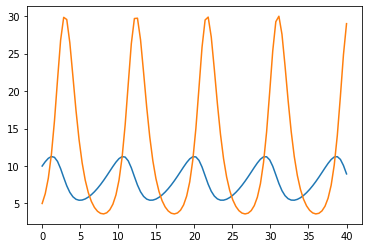

In [14]:
alpha = 0.25
beta = 0.02
delta = 0.25
gamma = 2


def pp_ode(state, t):
    x,y = state
    dx = alpha*x -beta*x*y
    dy = delta*x*y - y*gamma
    return [dx, dy]

t = np.linspace(0,40,100)
sol = odeint(pp_ode,y0 =[10,5], t=t)

plt.plot(t, sol[:,0])
plt.plot(t, sol[:,1])

inp_dat = np.array([t, sol[:,0], sol[:,1]])

In [18]:
test_inst = predprey_pinn(epochs=10, data= inp_dat, c0 =[10,5])

In [11]:
inp_dat.shape

(3, 100)

Running adam train once:

Epoch 0, loss: 0.23603315651416779, beta_param: 0.02, gamma_param: 2
Epoch 1, loss: 0.2267903834581375, beta_param: 0.02, gamma_param: 2
Epoch 2, loss: 0.2195354700088501, beta_param: 0.02, gamma_param: 2
Epoch 3, loss: 0.2114081084728241, beta_param: 0.02, gamma_param: 2
Epoch 4, loss: 0.20379692316055298, beta_param: 0.02, gamma_param: 2
Epoch 5, loss: 0.19838380813598633, beta_param: 0.02, gamma_param: 2
Epoch 6, loss: 0.19548077881336212, beta_param: 0.02, gamma_param: 2
Epoch 7, loss: 0.19437432289123535, beta_param: 0.02, gamma_param: 2
Epoch 8, loss: 0.1907251477241516, beta_param: 0.02, gamma_param: 2
Epoch 9, loss: 0.1887803077697754, beta_param: 0.02, gamma_param: 2


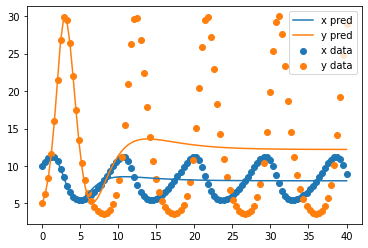

In [19]:
test_inst.adam_train()

After several runs

Epoch 0, loss: 0.0005453241756185889, beta_param: 0.02, gamma_param: 2
Epoch 1, loss: 0.0001740516017889604, beta_param: 0.02, gamma_param: 2
Epoch 2, loss: 7.50718972994946e-05, beta_param: 0.02, gamma_param: 2
Epoch 3, loss: 5.512431380338967e-05, beta_param: 0.02, gamma_param: 2
Epoch 4, loss: 4.5014898205408826e-05, beta_param: 0.02, gamma_param: 2
Epoch 5, loss: 3.80473502445966e-05, beta_param: 0.02, gamma_param: 2
Epoch 6, loss: 3.25711807818152e-05, beta_param: 0.02, gamma_param: 2
Epoch 7, loss: 2.981994293804746e-05, beta_param: 0.02, gamma_param: 2
Epoch 8, loss: 2.495665285096038e-05, beta_param: 0.02, gamma_param: 2
Epoch 9, loss: 2.4334365662070923e-05, beta_param: 0.02, gamma_param: 2


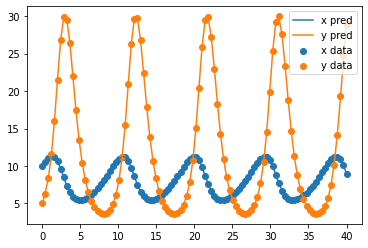

In [8]:
test_inst.adam_train()

Note: This converges much slower than just running on the data

Test with fewer datapoints:


In [17]:
ids = np.random.choice(range(inp_dat.shape[1]), size = 10)
sample_data = inp_dat[:,ids]

In [18]:
test_inst2 = predprey_pinn(epochs=10, data = sample_data, c0 =[10,5])


Epoch 0, loss: 1.4953633353798068e-06, beta_param: 0.02, gamma_param: 2
Epoch 1, loss: 1.4808708783675684e-06, beta_param: 0.02, gamma_param: 2
Epoch 2, loss: 8.252820407506078e-06, beta_param: 0.02, gamma_param: 2
Epoch 3, loss: 1.4049605852051172e-06, beta_param: 0.02, gamma_param: 2
Epoch 4, loss: 1.4179156551108463e-06, beta_param: 0.02, gamma_param: 2
Epoch 5, loss: 3.3056655865948414e-06, beta_param: 0.02, gamma_param: 2
Epoch 6, loss: 1.3165924883651314e-06, beta_param: 0.02, gamma_param: 2
Epoch 7, loss: 1.2926308272653841e-06, beta_param: 0.02, gamma_param: 2
Epoch 8, loss: 1.2641256716960925e-06, beta_param: 0.02, gamma_param: 2
Epoch 9, loss: 1.3426794112092466e-06, beta_param: 0.02, gamma_param: 2


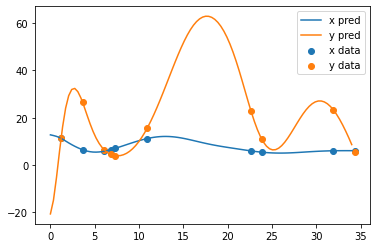

In [22]:
test_inst2.adam_train()

In [23]:
class Duo_net(torch.nn.Module):
    def __init__(self, n_in = 1, n_out =1):
        super(Duo_net, self).__init__()

        self.tanh = torch.nn.Tanh()

        self.layer10 = torch.nn.Linear(n_in,20)
        self.layer11 = torch.nn.Linear(n_in,20)

        self.layer20 = torch.nn.Linear(20,20)
        self.layer21 = torch.nn.Linear(20,20)

        self.layer_out0 = torch.nn.Linear(20,n_out)
        self.layer_out1 = torch.nn.Linear(20,n_out)

    def forward(self, x):
        x0 = self.layer10(x)
        x0 = self.tanh(x0)
        x0 = self.layer20(x0)
        x0 = self.tanh(x0)
        x0 = self.layer_out0(x0)

        x1 = self.layer11(x)
        x1 = self.tanh(x1)
        x1 = self.layer20(x1)
        x1 = self.tanh(x1)
        x1 = self.layer_out0(x1)

        return x0, x1

In [25]:
class rk_pp_pinn:
    """ Instance of Runge kutta scheme PINN
    for predator prey model
    """

    def __init__(self, dt, xdata,t_dat, q = 100):
        self.model = Duo_net(n_in=2,n_out=q+1)
        self.adam_optimizer = torch.optim.Adam(params = self.model.parameters(), lr = 0.001)
        butcher_file = np.float32(np.loadtxt('Butcher_IRK100.txt', ndmin = 2))

        self.IRK_weights = torch.Tensor(np.reshape(butcher_file[0:q**2+q], (q+1,q)))
        self.IRK_times = torch.Tensor(butcher_file[q**2+q:])

        x0s,x1s = xdata 
        self.x0s = torch.Tensor(x0s)
        self.x1s = torch.Tensor(x1s)
        self.t_dat = t_dat
        self.dt = dt
        self.epochs = 10
        
        self.alpha = 0.25
        self.beta = 0.02
        self.delta = 0.25
        self.gamma = 2
    
    def wrap_grad(self, f,x):
            return torch.autograd.grad(f,x,
            grad_outputs=torch.ones_like(x),
            retain_graph=True,
            create_graph=True)[0]
    
    def test(self):
        x,y = self.model(self.x0s)
        print(x.shape)
        


    def loss(self):
        x1, y1 = self.model(self.x1s)
        x = x1[:,:-1]
        y = y1[:,:-1]

    
        F0 = self.alpha*x -self.beta*x*y
        F1 = self.delta*x*y -y*self.gamma
        
        x0 = x1 - self.dt*torch.matmul(F0,self.IRK_weights.T)
        y0 = y1 - self.dt*torch.matmul(F1,self.IRK_weights.T)
        
        l0 = torch.mean((self.x0s[:,0].reshape(-1,1) - x0)**2)
        l1 = torch.mean((self.x0s[:,1].reshape(-1,1) - y0)**2)

        return l0 + l1

    
    def plot_preds(self):
        xs, ys = self.model(self.x1s)
        # plt.scatter(self.x0s[:,0].detach() , xs[:,-1].detach(), label = 'x_pred')
        # plt.scatter(self.x0s[:,1].detach() , ys[:,-1].detach(), label = 'y_pred')
        plt.scatter(self.t_dat, xs[:,-1].detach(), label = 'x_pred' )
        plt.scatter(self.t_dat, ys[:,-1].detach(), label = 'y_pred' )
        plt.legend()

        
    
    def adam_train(self):
            steps = 1000
            self.model.train()
            for epoch in range(self.epochs):
                for step in range(steps):
                    def closure():
                        self.adam_optimizer.zero_grad()
                        loss = self.loss()
                        loss.backward()
                        return loss
                    self.adam_optimizer.step(closure=closure)
                print(f'Epoch {epoch}, loss: {self.loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
            self.plot_preds()



Copying the data generation code again

In [48]:
alpha = 0.25
beta = 0.02
delta = 0.25
gamma = 2

N = 200

def pp_ode(state, t):
    x,y = state
    dx = alpha*x -beta*x*y
    dy = delta*x*y - y*gamma
    return [dx, dy]

t = np.linspace(0,40,10000)
sol = odeint(pp_ode,y0 =[10,5], t=t)
data_rk = np.array([sol[:,0], sol[:,1]]).T

# idx_t0 = 20
# idx_t1 = 180
# dt = t[idx_t1] - t[idx_t0]

d_id = 1000
ids0 = np.random.choice(len(t)-d_id, N)
ids1 = ids0 + d_id

dt = t[ids1[0]] - t[ids0[0]]
t0s = t[ids0]
#t1s = t[ids1]

x1s = data_rk[ids1]
x0s = data_rk[ids0]
rk_samples = [x0s,x1s]


In [49]:
rk_test = rk_pp_pinn(dt, rk_samples, t_dat=t0s, q = 100)

Epoch 0, loss: 0.0422130711376667, beta_param: 0.02, gamma_param: 2
Epoch 1, loss: 0.038544364273548126, beta_param: 0.02, gamma_param: 2
Epoch 2, loss: 0.04269007220864296, beta_param: 0.02, gamma_param: 2
Epoch 3, loss: 0.10343065857887268, beta_param: 0.02, gamma_param: 2
Epoch 4, loss: 0.0331563726067543, beta_param: 0.02, gamma_param: 2
Epoch 5, loss: 0.032884035259485245, beta_param: 0.02, gamma_param: 2
Epoch 6, loss: 0.03010696917772293, beta_param: 0.02, gamma_param: 2
Epoch 7, loss: 0.028697315603494644, beta_param: 0.02, gamma_param: 2
Epoch 8, loss: 0.027399497106671333, beta_param: 0.02, gamma_param: 2
Epoch 9, loss: 0.026172582060098648, beta_param: 0.02, gamma_param: 2


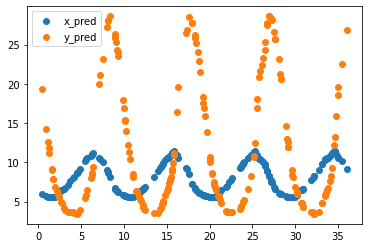

In [55]:
rk_test.adam_train()

In [52]:
dt

4.000400040004003